In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
import random
import torch
import os

from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import Input, Dense, Dropout, Bidirectional, CuDNNLSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, concatenate, MaxPool1D, AvgPool1D, Flatten, SpatialDropout1D, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2

from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve

Using TensorFlow backend.


In [2]:
def roc_auc_score_modified(y_true, y_pred):
    
    # to tackle problems where shuffled batches only contains 1 class
    # return 0.5, an underestimate of the actual metric
    
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return 0.5

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score_modified, (y_true, y_pred), tf.double)

def get_callbacks(file_path = None):
    earlystop = EarlyStopping(monitor='val_auroc', mode='max', verbose=1, patience=21, restore_best_weights=True)

    if file_path:
        checkpoint = ModelCheckpoint(file_path, monitor='val_auroc', verbose=1, save_best_only=True, mode='max')
        call_backs = [checkpoint,earlystop]
    else:
        call_backs = [earlystop]
    return call_backs

def get_model(num_features):    
    
    network_input = Input(shape=(1800, num_features))
    x = Conv1D(64, kernel_size = 5, padding = "valid", kernel_initializer = "he_uniform", kernel_regularizer=l2(0.02))(network_input)
    x = MaxPool1D(pool_size=3)(x) 
    x = Conv1D(64, kernel_size = 5, padding = "valid", kernel_initializer = "he_uniform", kernel_regularizer=l2(0.02))(x)
    x = MaxPool1D(pool_size=3)(x) 
    x = Conv1D(64, kernel_size = 5, padding = "valid", kernel_initializer = "he_uniform", kernel_regularizer=l2(0.02))(x)
    x = MaxPool1D(pool_size=3)(x) 

    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    network_output = Dense(1, activation='sigmoid')(x)

    model = Model(network_input, network_output)

    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3),
                  metrics=['acc', auroc])
    return model

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
SEED = 123
seed_everything(123)

In [5]:
%%time

EPOCHS = 200
BATCH_SIZE = 512

for n in range(1,6,1):

    print(f'Training Model - Fold {n}')

    X_train = np.load(f'../input/f{n}-final/Fold{n}_train_data.npy')
    y_train = np.load(f'../input/f{n}-final/Fold{n}_train_label.npy')
    X_val = np.load(f'../input/f{n}-final/Fold{n}_val_data.npy')
    y_val = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')

    print(X_train.shape)
    assert X_train.shape[0] == y_train.shape[0], 'Training file data and label doesnt match'
    assert X_val.shape[0] == y_val.shape[0], 'Validation file data and label doesnt match'

    file_path = f'cnn_fold{n}_best_weights.hdf5'
    call_backs = get_callbacks(file_path)

    model = get_model(X_train.shape[-1])

    model.fit(X_train, y_train, 
              batch_size=BATCH_SIZE, epochs = EPOCHS, 
              callbacks=call_backs, 
              validation_data=(X_val, y_val), 
              verbose=1)
    print('\nLoading best weight from file\n')
    model.load_weights(file_path)

    if n == 1:
        y_oof = model.predict(X_val)
    else:
        y_pred = model.predict(X_val)
        y_oof = np.row_stack([y_oof, y_pred])

    del X_train, y_train, X_val, y_val, model

    gc.collect()

Training Model - Fold 1
(15985, 1800, 12)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 15985 samples, validate on 3997 samples
Epoch 1/200
15985/15985 [==============================] - 11s 688us/step - loss: 11.7783 - acc: 0.7302 - auroc: 0.6015 - val_loss: 8.7264 - val_acc: 0.7593 - val_auroc: 0.7059

Epoch 00001: val_auroc improved from -inf to 0.70591, saving model to cnn_fold1_best_weights.hdf5
Epoch 2/200
15985/15985 [==============================] - 4s 224us/step - loss: 7.2471 - acc: 0.7733 - auroc: 0.7140 - val_loss: 5.8551 - val_acc: 0.7716 - val_auroc: 0.7253

Epoch 00002: val_auroc improved from 0.70591 to 0.72528, saving model to cnn_fold1_best_weights.hdf5
Epoch 3/200
15985/15985 [==============================] - 4s 224us/step - loss: 4.9358 - acc: 0.7740 - auroc: 0.7278 - val_loss: 4.0501 - val_acc: 0.7671 - val_auroc: 0.7224

Epoch 00003: val_auroc did not improve from 0.72528
Epoch 4/

In [6]:
for n in range(1,6,1):
    if n == 1:
        y_true = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = y_true.reshape((y_true.shape[0],1))
    else:
        y_fold = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = np.row_stack([y_true, y_fold.reshape((y_fold.shape[0], 1))])

In [7]:
oof_rocauc = roc_auc_score(y_true, y_oof)
print(f'OOF ROCAUC Score : {oof_rocauc:.4f}')

OOF ROCAUC Score : 0.7337


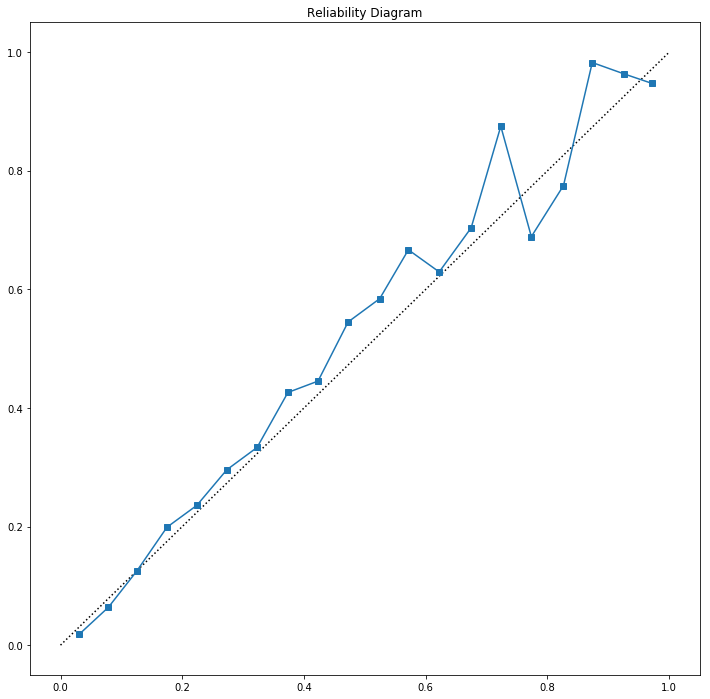

In [8]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_oof, n_bins =20)

plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='OOF prediction')
plt.title(f'Reliability Diagram')
plt.show()

In [9]:
np.save('CNN_oof_predictions.npy', y_oof)